In [17]:
import pandas as pd
import spacy
from spacy.matcher import Matcher
from spacy.tokens import Span
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re

import networkx as nx

import glob
import string

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [2]:
tweet_files = glob.glob('../Data/Tweets_scraped_2000_*.csv')
news_files = glob.glob('../Data/corona_news_scraped_on_2*.csv')

In [3]:
print('\n'.join('Tweet File {}: {}'.format(*k) for k in enumerate(tweet_files)))

Tweet File 0: ../Data\Tweets_scraped_2000_24th_CORONA_COVID.csv
Tweet File 1: ../Data\Tweets_scraped_2000_26th_CORONA_COVID.csv
Tweet File 2: ../Data\Tweets_scraped_2000_29th_CORONA_COVID.csv


In [4]:
print('\n'.join('News File {}: {}'.format(*k) for k in enumerate(news_files)))

News File 0: ../Data\corona_news_scraped_on_24th_march.csv
News File 1: ../Data\corona_news_scraped_on_26th_march.csv
News File 2: ../Data\corona_news_scraped_on_29th_march.csv


In [5]:
all_news = pd.concat([pd.read_csv(f) for f in news_files],ignore_index =True)
all_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658 entries, 0 to 657
Data columns (total 2 columns):
datetime    658 non-null object
text        658 non-null object
dtypes: object(2)
memory usage: 10.4+ KB


In [6]:
all_tweets = pd.concat([pd.read_csv(f) for f in tweet_files],ignore_index =True)
all_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 5 columns):
geo               6 non-null object
tweet             6000 non-null object
user_handle       6000 non-null object
location          4370 non-null object
cleaned_tweets    5995 non-null object
dtypes: object(5)
memory usage: 234.5+ KB


In [7]:
all_tweets.drop(columns=['geo','tweet','user_handle','location'],axis = 1,inplace=True)
all_tweets.rename(columns={'cleaned_tweets':'text'},inplace=True)
all_tweets.head()

,text
0,punjab cm captain amarinder singh has sought ...
1,excited to announce that we have launched cov...
2,this corona is going to teach us a lot of thi...
3,public health expes including dr anthony fauc...
4,a spencer thank you everyone for your incredi...


In [8]:
documents = pd.DataFrame()
documents['text'] = pd.concat([all_news.text,all_tweets.text],axis =0 ,ignore_index=True)
documents.head()

,text
0,"2 new positive cases reported, positive cases ..."
1,"23-year old, with the recent travel history to..."
2,Coronavirus lockdown in Maharashtra: What's ex...
3,Visual from Srinagar as the complete lockdown ...
4,QuoteThe total number of positive Coronavirus...


In [9]:
documents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6658 entries, 0 to 6657
Data columns (total 1 columns):
text    6653 non-null object
dtypes: object(1)
memory usage: 52.1+ KB


In [10]:
documents = documents.sample(frac=1).reset_index(drop=True)

In [11]:
documents.head()

,text
0,in turkey people have staed to leave food pac...
1,covid c china o originated v virus i in d dec...
2,Delhi CM Arvind Kejriwal: Follow what PM Modi ...
3,help slow the spread of covid and identify at ...
4,is offering FREE HealthCare POAs living wills ...


In [12]:
nlp = spacy.load('en_core_web_sm')

### Cleaning Data for NLP

In [13]:
# Remove HTML Tags
def remove_html(text):
    soup = BeautifulSoup(text,'lxml')
    html_free_text = soup.get_text()
    return html_free_text

# Remove Punctuations
def punctuation_remover(text):
    punctuation_free_text = " ".join([word for word in text if word \
                                    not in string.punctuation])
    return punctuation_free_text


# Stop Word Removal
cached_stop_words = stopwords.words('english') # Provides 70 X Speedup
def stop_words_remover(text):
#     text = text.lower().split()
    words = [word for word in text if \
             word not in cached_stop_words]
    return words

# Convert to lower case
def convert_to_lowercase(tokens):
    low = []
    for tok in tokens:
        low.append(tok.lower().strip())
    return low

# Lemmatization
def lemmatize_words(text):
    words = nlp(str(text))
    return [word.lemma_ for word in words if word.lemma_ != '-PRON-']  

def replace_urls(tokens):
    re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", tokens)
    return tokens


def remove_short_strings(text, length):
    array = []
    for word in text:
        if len(word) > length:
            array.append(word)
    return array

In [14]:
tokenized_documents = documents.copy()
tokenized_documents['text'] = tokenized_documents.text.astype(str)

In [15]:
def clean_text_for_tasks(text, for_pos_tagging = False):
    cleaned_text = remove_html(text)
    cleaned_text = replace_urls(cleaned_text)
    cleaned_text = word_tokenize(cleaned_text)
   
    
    if for_pos_tagging is False:
        cleaned_text = convert_to_lowercase(cleaned_text)
        cleaned_text = stop_words_remover(cleaned_text)
        cleaned_text = lemmatize_words(cleaned_text)
    cleaned_text = remove_short_strings(cleaned_text,2)
    cleaned_text = punctuation_remover(cleaned_text)
    
    return cleaned_text

In [18]:
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()
# from pandarallel import pandarallel
# pandarallel.initialize(progress_bar=True)

tokenized_documents['cleaned_text'] = tokenized_documents.text.progress_apply(clean_text_for_tasks)
# tokenized_documents['cleaned_text'] = tokenized_documents.text.parallel_apply(clean_text_for_tasks,axis = 1 )

In [19]:
tokenized_documents.head()

,text,cleaned_text
0,in turkey people have staed to leave food pac...,turkey people staed leave food packet road poo...
1,covid c china o originated v virus i in d dec...,covid china originate virus december
2,Delhi CM Arvind Kejriwal: Follow what PM Modi ...,delhi arvind kejriwal follow modi say stay indoor
3,help slow the spread of covid and identify at ...,help slow spread covid identify risk case soon...
4,is offering FREE HealthCare POAs living wills ...,offering free healthcare poas live will tempor...


### Using Linguistic Features such as Named Entity Recognition and Parts-of-Speech

We will use these features to gain more insights into the most talked about entities. Which will allow us 
to further explore into those topics.

In [20]:
tokenized_documents[200:300].head(10)

,text,cleaned_text
200,again one week too late hundreds of thousands...,one week late hundred thousand people return a...
201,President Donald Trump wants America to get ba...,president donald trump want america get back b...
202,my hands are shaking and tears are rolling do...,hand shake tear roll face wrong become nurse w...
203,indiaunderlockdown jana sena chief to donate ...,indiaunderlockdown jana sena chief donate cror...
204,USNSComfo Next Stop New York City our nation ...,usnscomfo next stop new york city nation speci...
205,Woh repeating called COVID a hoax TrumpLiesAme...,woh repeat call covid hoax trumpliesamericansd...
206,covid hero year old italian priest gave up ven...,covid hero year old italian priest give ventil...
207,if you need suppo during the covid crisis ple...,need suppo covid crisis please call helpline e...
208,lin whenever i ask other grad students how th...,lin whenever ask grad student covid common res...
209,iceland has performed rather extensive screen...,iceland perform rather extensive screening asy...


In [21]:
from spacy import displacy

doc_1 = nlp(tokenized_documents.iloc[207].text)
displacy.render(doc_1, style="ent")

In [22]:
doc_1 = nlp(tokenized_documents.iloc[400].text)
displacy.render(doc_1, style="ent")

#### We can see that spacy does not recognize the Corona Virus 

In [23]:
# sample_texts = tokenized_documents[200:300].text.apply(lambda x : clean_text_for_tasks(x ,for_pos_tagging=True))
# sample_texts = tokenized_documents[200:300].cleaned_text
training_sample_data = tokenized_documents.sample(10,random_state=10)
for  text in training_sample_data.text:
    test_doc = nlp(text)
    displacy.render(test_doc, style="ent")
    print('---------')

---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


#### We will retrain the model to detect few of these entities

In [24]:
#To-DO

In [25]:
# from spacy.symbols import nsubj, VERB,NORP, NOUN, PRON

# verbs = set()
# for possible_subject in test_doc:
#     if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
#         verbs.add(possible_subject.head)
# print(verbs)

In [26]:
# from spacy import displacy
# displacy.render(test_doc, style="ent")

### Find POS tags for each document like NOUN and PROPN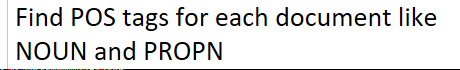

In [27]:
docs_for_pos = tokenized_documents.copy()
docs_for_pos['cleaned_for_pos_tagging'] = tokenized_documents.text.apply(lambda x : clean_text_for_tasks(x ,for_pos_tagging=True))   

In [28]:
def get_pos_tags():

    INTERTESTED_POS_TAGS = ['NOUN' , 'PROPN' ]
    tags = []
    for index,sentence in tqdm_notebook(docs_for_pos.iterrows(),total = len(docs_for_pos)):
        pos= {}
        tokenized = nlp(sentence.cleaned_for_pos_tagging)
    #     tokenized = nlp(text)
        for token in tokenized:
            if token.pos_ in INTERTESTED_POS_TAGS:
    #                 print(token.text,token.pos_)
                pos['word'] = token.text
                pos['pos_tag'] = token.pos_
                tags.append(pos)
    return tags

In [29]:
# from joblib import Parallel, delayed
# tags = Parallel(n_jobs=8,backend='multiprocessing')(
#             delayed(get_pos_tags())
# #         )
# from pandarallel import pandarallel
# pandarallel.initialize(progress_bar=True)

# tags = docs_for_pos.parallel_apply(get_pos_tags,axis =1 )
tags = get_pos_tags()

In [30]:
tags_df = pd.DataFrame(tags)
tags_df.head()

,pos_tag,word
0,NOUN,covid
1,NOUN,covid
2,NOUN,covid
3,NOUN,covid
4,NOUN,covid


In [31]:
tags_size = tags_df.groupby(['pos_tag', 'word']).size()

In [32]:
tags_noun = tags_df.loc[tags_df.pos_tag == 'NOUN']
tags_noun.head()

,pos_tag,word
0,NOUN,covid
1,NOUN,covid
2,NOUN,covid
3,NOUN,covid
4,NOUN,covid


In [33]:
from pandas.core.common import flatten

all_noun_words =list(flatten(tags_df.word.values))

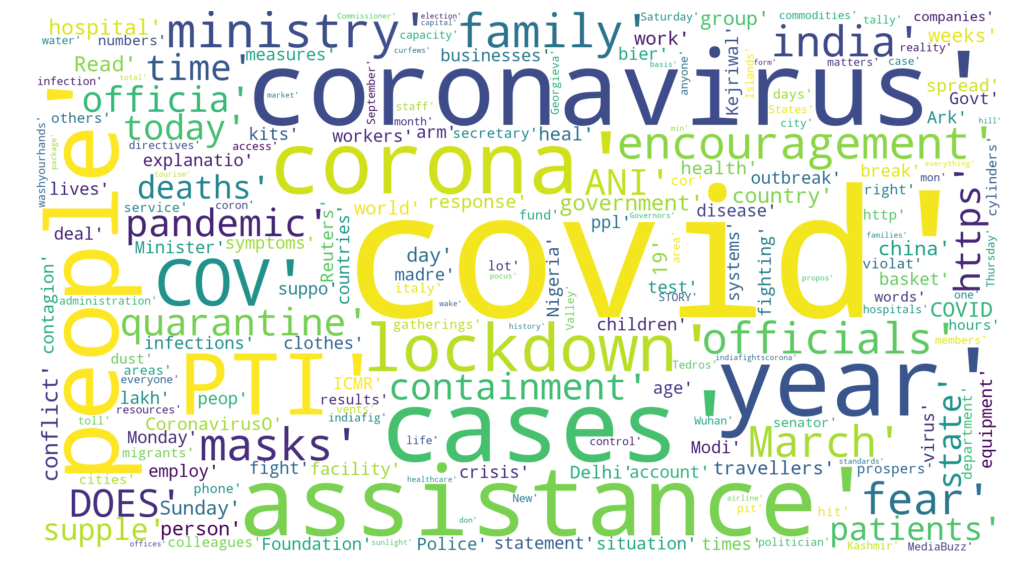

In [34]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

def generate_word_cloud(words):
    wordcloud = WordCloud(background_color = 'white',collocations=False,width=1920, height=1080).generate(str(words))
    plt.figure(figsize= (20,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

generate_word_cloud(all_noun_words)  

In [35]:
from collections import Counter

noun_counts = Counter(tags_df.word)

In [36]:
print(noun_counts.most_common(30))

[('covid', 1987), ('COVID', 1067), ('coronavirus', 512), ('cases', 501), ('people', 488), ('assistance', 467), ('year', 459), ('PTI', 357), ('corona', 332), ('lockdown', 306), ('family', 279), ('encouragement', 268), ('fear', 248), ('quarantine', 239), ('pandemic', 237), ('DOES', 236), ('ministry', 235), ('containment', 234), ('time', 230), ('https', 228), ('ANI', 227), ('officia', 225), ('today', 213), ('patients', 204), ('officials', 201), ('COV', 188), ('March', 182), ('deaths', 181), ('state', 173), ('supple', 172)]


In [37]:
most_common_nouns = noun_counts.most_common(40)
for i in range(3):
    most_common_nouns.pop(0)

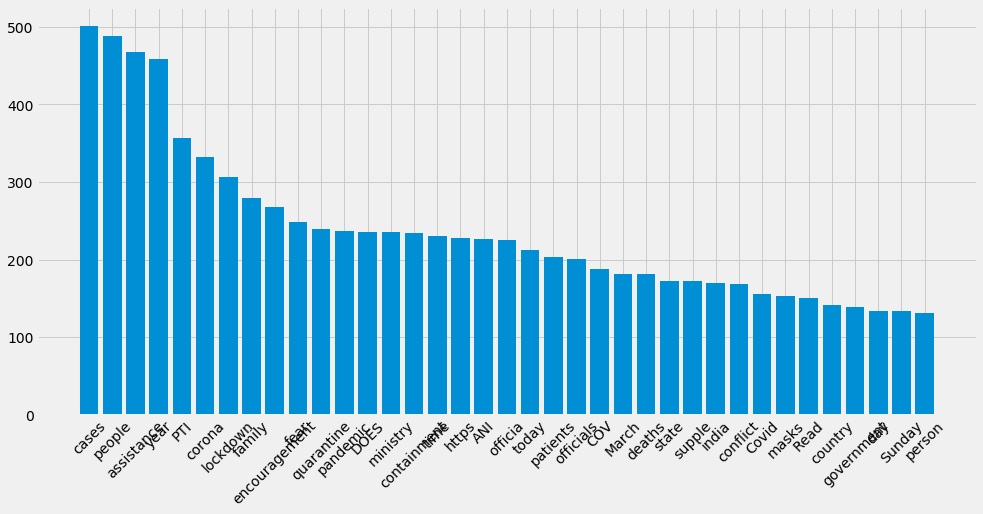

In [38]:
plt.style.use('fivethirtyeight')
# plt.title('Most Commonly Used NOUNs')
plt.figure(figsize=(15,7))
plt.xticks(rotation='45')
plt.bar(*zip(*most_common_nouns))
plt.show()


### Now, let us find the most common occuring Entities

In [39]:
def get_entity_tags():

    INTERTESTED_ENTITY_TAGS = ['NORP' , 'GPE' ,'ORG', 'PRODUCT', 'LOC', 'PERSON']
    tags = []
    for index,sentence in tqdm_notebook(docs_for_pos.iterrows(),total = len(docs_for_pos)):
        entity= {}
        tokenized = nlp(sentence.cleaned_for_pos_tagging)
        for ent in tokenized.ents:
            if ent.label_ in INTERTESTED_ENTITY_TAGS:
                entity['word'] = ent.text
                entity['entity_tag'] = ent.label_
                tags.append(entity)
    return tags

In [40]:
entities = get_entity_tags()

In [41]:
# entities

In [42]:
entities_df = pd.DataFrame(entities)

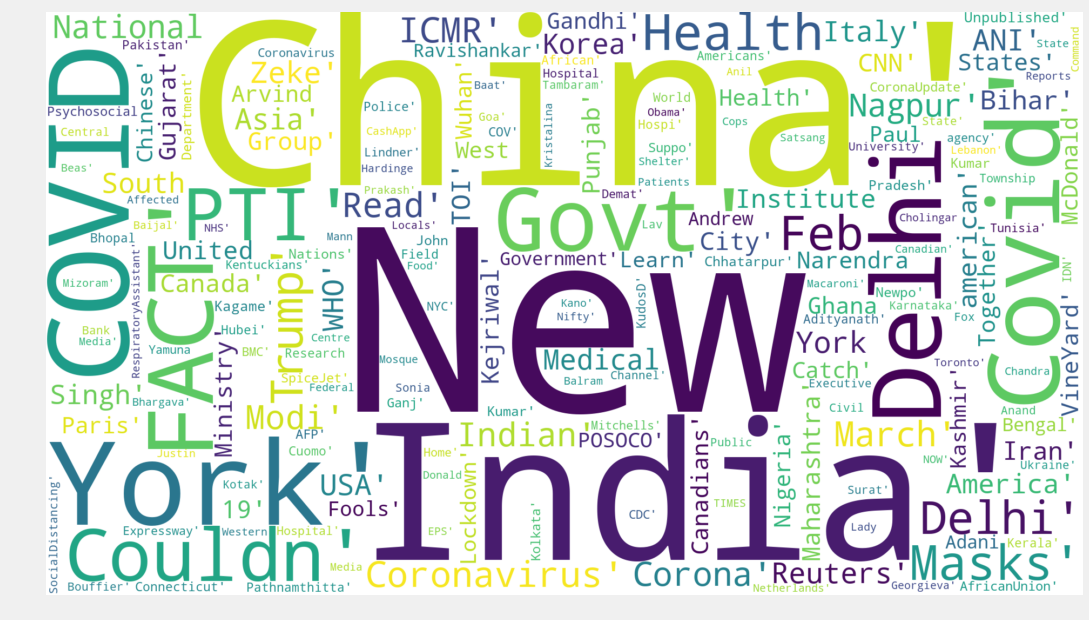

In [43]:
all_entities =list(flatten(entities_df.word.values))
generate_word_cloud(all_entities)  

In [44]:
entity_counts = Counter(entities_df.word)

In [45]:
entity_counts.most_common(30)

[('China', 150),
 ('New York', 113),
 ('India', 113),
 ('FACT', 68),
 ('Covid', 66),
 ('Couldn', 60),
 ('PTI', 60),
 ('Delhi Govt', 52),
 ('Feb Masks', 44),
 ('COVID March', 36),
 ('ICMR', 35),
 ('Trump', 33),
 ('Indian', 32),
 ('Coronavirus', 32),
 ('Corona', 31),
 ('Nagpur', 31),
 ('Delhi', 31),
 ('Zeke', 27),
 ('Reuters', 25),
 ('USA', 25),
 ('WHO', 25),
 ('Asia', 24),
 ('Bihar', 21),
 ('Read', 21),
 ('South Korea', 20),
 ('Italy', 20),
 ('TOI', 20),
 ('ANI', 19),
 ('America', 19),
 ('Modi', 18)]

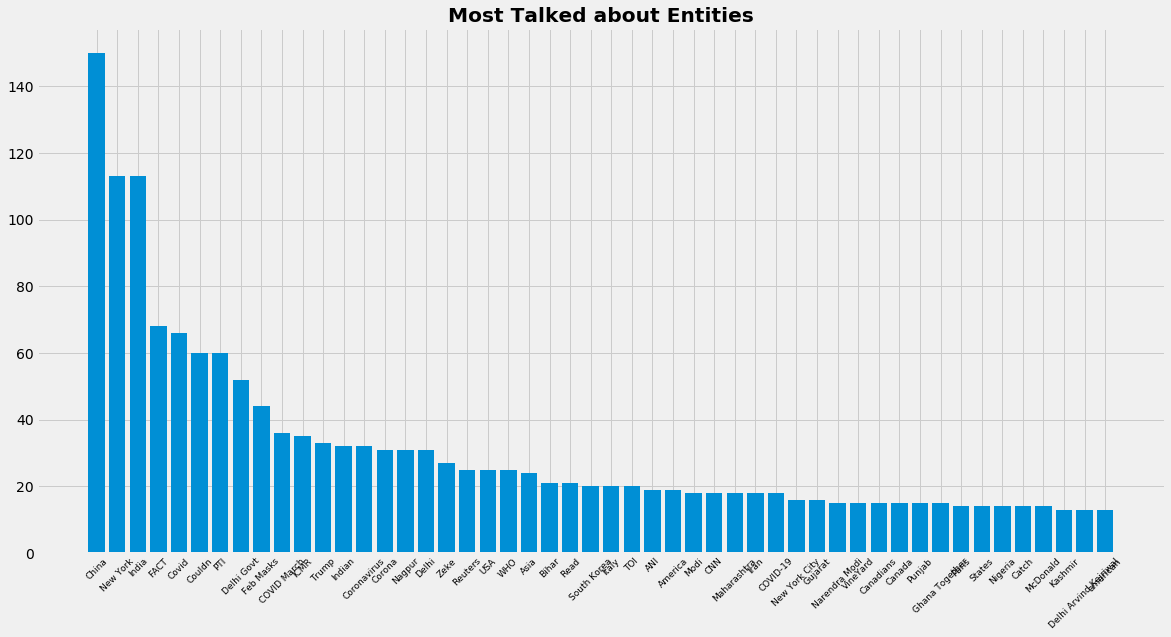

In [46]:
plt.figure(figsize=(18,9))
plt.xticks(rotation='45',fontsize = 9)
plt.bar(*zip(*entity_counts.most_common(50)))
plt.title(label = 'Most Talked about Entities',fontweight = 'bold')
plt.show()


#### Let's find some documents swith the Top enities that we found above

In [48]:
entity_filtered_docs = docs_for_pos[(docs_for_pos.cleaned_for_pos_tagging.str.contains('India')) 
                                    | ( docs_for_pos.cleaned_for_pos_tagging.str.contains('WHO'))
                                    | ( docs_for_pos.cleaned_for_pos_tagging.str.contains('FACT'))
                                    | ( docs_for_pos.cleaned_for_pos_tagging.str.contains('Maharastra'))]

In [49]:
entity_filtered_docs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 286 entries, 24 to 6629
Data columns (total 3 columns):
text                       286 non-null object
cleaned_text               286 non-null object
cleaned_for_pos_tagging    286 non-null object
dtypes: object(3)
memory usage: 8.9+ KB


In [50]:
for  text in entity_filtered_docs.sample(10).text:
    test_doc = nlp(text)
    displacy.render(test_doc, style="ent")
    print('---------')

---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


### Entity Relations using Knowledge Graph

We have to do some dependency parsing on the texts to find the Subjects and objects and find the ROOT word i.e. the dependency between them

In [51]:
# https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/?utm_source=blog&utm_medium=introduction-information-extraction-python-spacy

def get_entity_pairs(text):

    entity_1 = ''
    entity_2 = ''

    previous_dependency = ''
    previous_text = ''

    prefix = ''
    modifier = ''

    for token in nlp(text):
        if token.dep_ != 'punct':
            if token.dep_ == 'compound':
                prefix = previous_text + " "+ token.text

         # check: token is a modifier or not
        if token.dep_.endswith("mod") == True:
            modifier = token.text
        # if the previous word was also a 'compound' then add the current word to it
            if previous_dependency == "compound":
                  modifier = previous_text + " "+ token.text

      ## chunk 3
        if token.dep_.find("subj") == True:
            entity_1 = modifier +" "+ prefix + " "+ token.text
            prefix = ""
            modifier = ""
            previous_text = ""
            previous_dependency = ""      

      ## chunk 4
        if token.dep_.find("obj") == True:
            entity_2 = modifier +" "+ prefix +" "+ token.text

      ## chunk 5  
      # update variables
        prv_tok_dep = token.dep_
        prv_tok_text = token.text
  #############################################################
    return [entity_1.strip(), entity_2.strip()]

In [52]:
entity_pairs = [get_entity_pairs(text) for text in tqdm_notebook(entity_filtered_docs.text)]

In [53]:
entity_pairs[5:25]

[['you', 'seconds'],
 ['you', 'seconds'],
 ['Solidarity that', 'cli'],
 ['you', 'seconds'],
 ['health ministry', '918  Covid-19 cases'],
 ['Investment Managers', 'coronavirus  management outbrea'],
 ['ADANI FOUNDATION', 'Rs COVID'],
 ['system', 'renewable  generation basket'],
 ['India  Ministry', 'Management Act'],
 ['COVID WHO', 'WuhanVirus'],
 ['ADANI FOUNDATION', 'Rs COVID'],
 ['social  they', 'best  them'],
 ['Corona Hon', 'kind  PM encouragement'],
 ['you', 'seconds'],
 ['three  Services who', 'March'],
 ['deadly  which', 'Indian  envoy'],
 ['three  Services who', 'March'],
 ['ADANI FOUNDATION', 'Rs COVID'],
 ['you', 'seconds'],
 ['1,12,188  which', 'consecutive  September']]

In [54]:
def get_relation(text):
    
    doc = nlp(text)
    matcher =  Matcher(nlp.vocab)
    
    pattern = [
                {'DEP' : 'ROOT'},
                {'DEP' : 'prep', 'OP': '?'},
                {'DEP' : 'agent','OP': '?'},
                {'POS' : 'ADJ','OP' : '?' }
              ]
    
    matcher.add('matching_1', None , pattern)
    matches = matcher(doc)
    k = len(matches) - 1
    
    span = doc[matches[k][1]:matches[k][2]]
    
    return(span.text)

In [55]:
entity_relations = [get_relation(text) for text in tqdm_notebook(entity_filtered_docs.text)]

In [56]:
Counter(entity_relations).most_common(10)

[('mean', 49),
 ('adani', 32),
 ('evidence of', 22),
 ('transmitted through', 21),
 ('tested positive', 18),
 ('Read', 6),
 ('said', 6),
 ('is', 5),
 ('has', 4),
 ('withheld in', 4)]

In [57]:
def combine_entities_and_relations(entity_pairs , entity_relations):   
    entity_subjects = [i[0] for i in entity_pairs ]
    entity_objects  = [i[1] for i in entity_pairs ]

    entities_and_relations_df = pd.DataFrame({'subject': entity_subjects,
                                              'object' : entity_objects,
                                              'relation': entity_relations
                                             })

    entities_and_relations_df.drop_duplicates(subset=None, keep='first', inplace=True)
    
    return entities_and_relations_df

In [58]:
entities_and_relations_df = combine_entities_and_relations(entity_pairs , entity_relations)
entities_and_relations_df.relation.value_counts()

Read                     5
is                       5
said                     4
mean                     4
transmitted through      3
"                        3
has                      3
s                        2
confirmed                2
Ministry                 2
told                     2
says                     2
constitutes              1
put under statewide      1
put under                1
records                  1
asked                    1
fabricated               1
recovered in             1
PTI                      1
reduce overall           1
flattened                1
repos new                1
were                     1
says of                  1
praises                  1
wrote to                 1
responding to            1
reported                 1
tests positive           1
                        ..
look at                  1
delivered                1
adani                    1
visit                    1
arrested till            1
withheld in              1
i

### Computing the Entity relation for the entire corpus

In [59]:
entity_pairs_for_all_data = [get_entity_pairs(text) for text in tqdm_notebook(docs_for_pos.text)]

In [60]:
entity_relations_for_all_data = [get_relation(text) for text in tqdm_notebook(docs_for_pos.text)]

In [61]:
entities_and_relations_all = combine_entities_and_relations(entity_pairs_for_all_data , entity_relations_for_all_data)
entities_and_relations_all.relation.value_counts()

is                          213
are                          75
s                            71
said                         45
have                         41
let                          39
says                         37
help                         33
be                           31
has                          29
know                         23
was                          20
announced                    20
think                        19
reports                      18
stay                         18
tested positive              17
covid                        17
say                          17
launched                     16
take                         16
need                         16
Read                         15
m                            14
confirmed                    14
"                            13
had                          13
thank                        13
read                         12
hope                         12
                           ... 
elders  

In [62]:
def compute_and_plot_network(entities_and_relations_df , relation_text ):   
    network = nx.from_pandas_edgelist(entities_and_relations_df.loc[entities_and_relations_df.relation == relation_text],
                                      source= 'subject',
                                      target= 'object',
                                      edge_attr=True,
                                      create_using=nx.MultiDiGraph()
                                     )

    # Plot the network
    plt.figure(figsize=(14,6))
    pos = nx.spring_layout(network)
    nx.draw(network, 
            with_labels=True,
            arrows = True,
            font_size = 9,
            node_color='skyblue',
            edge_cmap=plt.cm.Blues,
            pos = pos,
           )
#     labels=nx.draw_networkx_labels(network,pos=pos,font_size=7)
    plt.show()

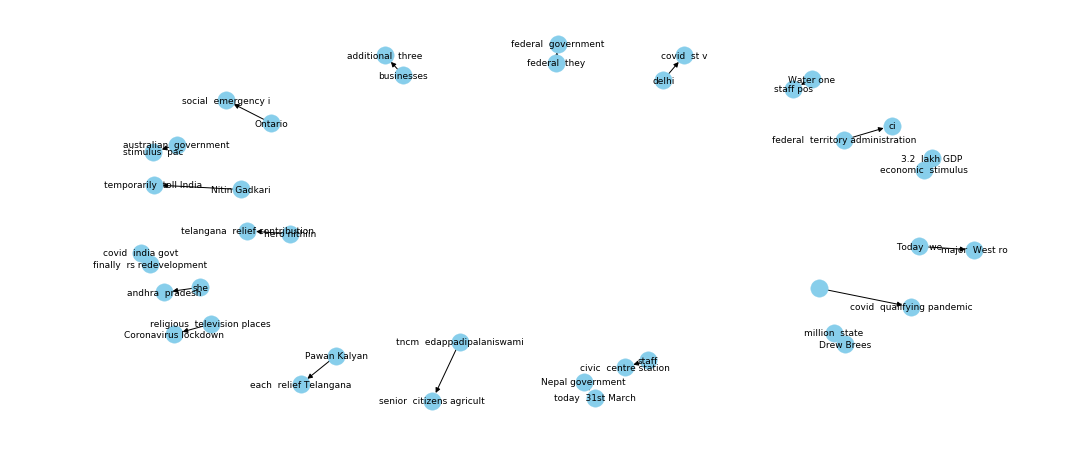

In [63]:
compute_and_plot_network(entities_and_relations_all,'announced')

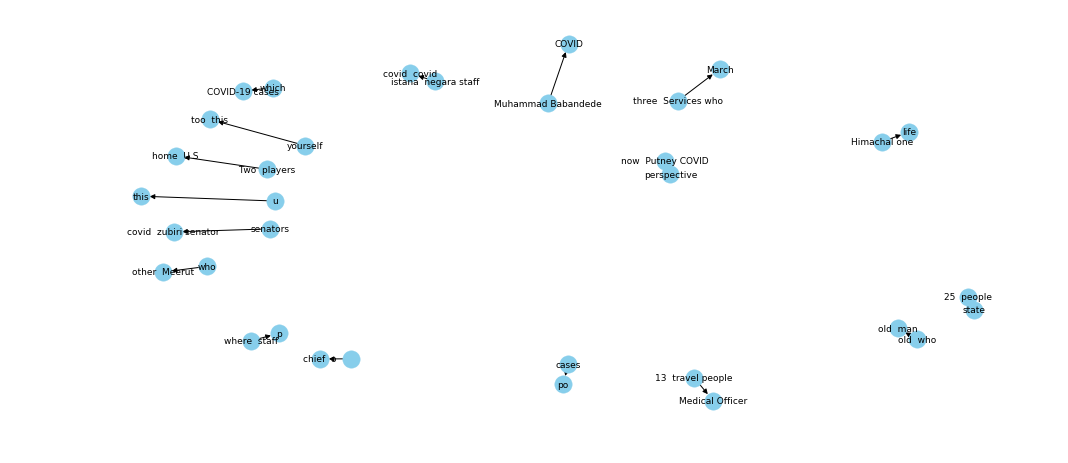

In [64]:
compute_and_plot_network(entities_and_relations_all,'tested positive')

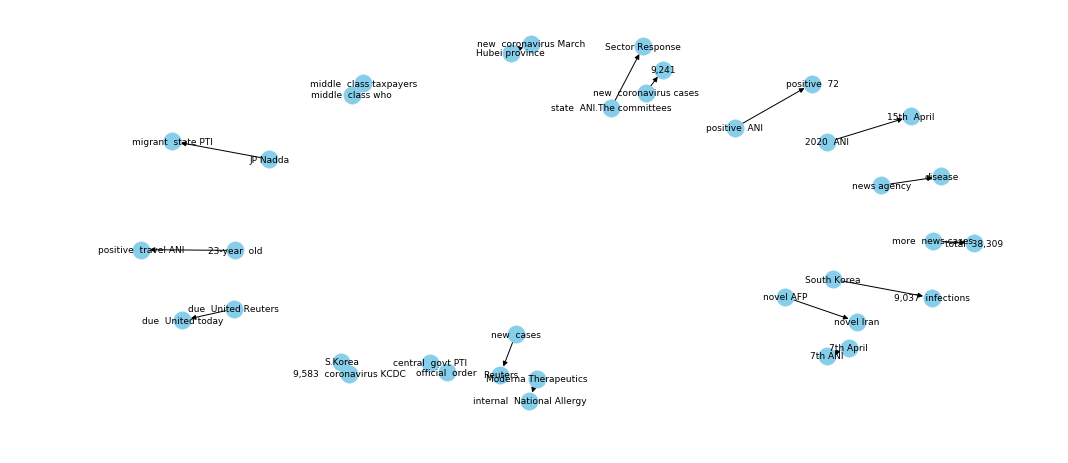

In [65]:
compute_and_plot_network(entities_and_relations_all,'reports')